# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 2048# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["tau21j1"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


20

In [12]:
X_train

array([[-0.16416514],
       [ 0.2952783 ],
       [-0.09383094],
       ...,
       [-0.87884235],
       [ 0.28405297],
       [ 0.3345213 ]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['tau21j1'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [02:22<3:52:08, 14.07s/it]


Epoch 10:

Generator training loss: -0.19040554888098618
Discriminator training loss: 0.4533089397546372

Generator validation loss: -0.22276595393653775
Discriminator validation loss: 0.48046613496835117


  2%|█▌                                                                            | 20/1000 [04:47<3:53:55, 14.32s/it]


Epoch 20:

Generator training loss: -0.26617014729748656
Discriminator training loss: 0.1638339716513626

Generator validation loss: -0.2944218338024421
Discriminator validation loss: 0.1608334220945835


  3%|██▎                                                                           | 30/1000 [07:05<3:42:39, 13.77s/it]


Epoch 30:

Generator training loss: -0.24153521673275474
Discriminator training loss: 0.33576067136040805

Generator validation loss: -0.2855674766126226
Discriminator validation loss: 0.3380781188607216


  4%|███                                                                           | 40/1000 [09:23<3:41:18, 13.83s/it]


Epoch 40:

Generator training loss: 0.05003051767574211
Discriminator training loss: 0.38846245030236376

Generator validation loss: -0.09184356485722495
Discriminator validation loss: 0.48204493962350436


  5%|███▉                                                                          | 50/1000 [11:41<3:39:28, 13.86s/it]


Epoch 50:

Generator training loss: 0.36295579666974115
Discriminator training loss: 0.25900490623517114

Generator validation loss: -0.0711352401947389
Discriminator validation loss: 0.4558261166341969


  6%|████▋                                                                         | 60/1000 [14:05<3:42:46, 14.22s/it]


Epoch 60:

Generator training loss: 0.42361793166301287
Discriminator training loss: 0.08897881401407588

Generator validation loss: -0.26099763163289086
Discriminator validation loss: 0.32393328882143146


  7%|█████▍                                                                        | 70/1000 [16:26<3:40:46, 14.24s/it]


Epoch 70:

Generator training loss: 0.4704144272973629
Discriminator training loss: 0.02485111480458866

Generator validation loss: -0.3007048356239913
Discriminator validation loss: 0.06488809075786686


  8%|██████▏                                                                       | 80/1000 [18:49<3:40:46, 14.40s/it]


Epoch 80:

Generator training loss: 0.7018172578082058
Discriminator training loss: 0.02180011443130747

Generator validation loss: -0.0009689033265248491
Discriminator validation loss: 0.04755448627659715


  9%|███████                                                                       | 90/1000 [21:11<3:33:56, 14.11s/it]


Epoch 90:

Generator training loss: 0.8036380963898747
Discriminator training loss: 0.03766557701925055

Generator validation loss: 0.1582994614956809
Discriminator validation loss: 0.016781990749610697


 10%|███████▋                                                                      | 99/1000 [23:20<3:34:46, 14.30s/it]


Epoch 100:

Generator training loss: 0.6824199485648526
Discriminator training loss: 0.015512336362194642

Generator validation loss: -0.01889127538516568
Discriminator validation loss: -0.03029665047089096

Epoch 100:


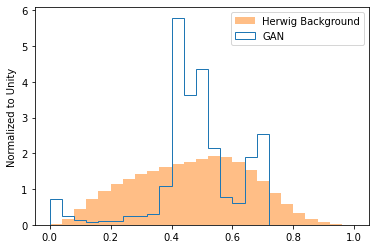

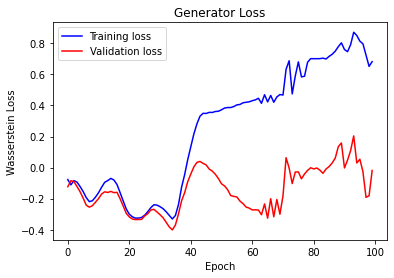

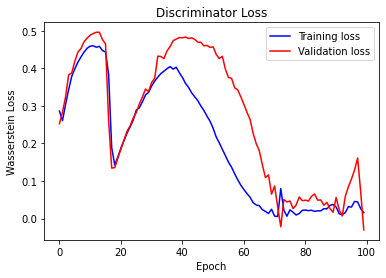

 11%|████████▍                                                                    | 110/1000 [25:55<3:28:39, 14.07s/it]


Epoch 110:

Generator training loss: 0.7745548700048623
Discriminator training loss: 0.018948418529919867

Generator validation loss: -0.02999625956548042
Discriminator validation loss: 0.03148793970181256


 12%|█████████▏                                                                   | 120/1000 [28:10<3:12:54, 13.15s/it]


Epoch 120:

Generator training loss: 0.7867376547042138
Discriminator training loss: 0.005465049775991789

Generator validation loss: -0.15106798818365472
Discriminator validation loss: 0.04208726165663512


 13%|██████████                                                                   | 130/1000 [30:31<3:23:56, 14.07s/it]


Epoch 130:

Generator training loss: 0.8137058664540775
Discriminator training loss: 0.0008715979610518882

Generator validation loss: -0.14562452389080016
Discriminator validation loss: 0.0033132816883391838


 14%|██████████▊                                                                  | 140/1000 [32:50<3:18:30, 13.85s/it]


Epoch 140:

Generator training loss: 0.8337072961317386
Discriminator training loss: 0.00032776292416494834

Generator validation loss: -0.06467532510029488
Discriminator validation loss: -0.009191132568063398


 15%|███████████▌                                                                 | 150/1000 [35:08<3:16:07, 13.84s/it]


Epoch 150:

Generator training loss: 0.8225745299800498
Discriminator training loss: 0.001872264360321165

Generator validation loss: -0.11371343399657578
Discriminator validation loss: 0.04777993222118401


 16%|████████████▎                                                                | 160/1000 [37:30<3:19:31, 14.25s/it]


Epoch 160:

Generator training loss: 0.8090452559984447
Discriminator training loss: 0.011161894753403644

Generator validation loss: -0.18036037463633742
Discriminator validation loss: 0.017043552470925937


 17%|█████████████                                                                | 170/1000 [39:50<3:13:07, 13.96s/it]


Epoch 170:

Generator training loss: 0.7850845654805502
Discriminator training loss: 0.0037160633488319003

Generator validation loss: -0.1334562467136344
Discriminator validation loss: -0.008517392380468424


 18%|█████████████▊                                                               | 180/1000 [42:09<3:09:38, 13.88s/it]


Epoch 180:

Generator training loss: 0.9152932665387138
Discriminator training loss: 0.004037480022594795

Generator validation loss: 0.06183350223620407
Discriminator validation loss: -0.002419233957656705


 19%|██████████████▋                                                              | 190/1000 [44:28<3:06:19, 13.80s/it]


Epoch 190:

Generator training loss: 0.7766794585139374
Discriminator training loss: 0.0037822274030897135

Generator validation loss: -0.11453776360779512
Discriminator validation loss: 0.04047418817816699


 20%|███████████████▎                                                             | 199/1000 [46:37<3:09:12, 14.17s/it]


Epoch 200:

Generator training loss: 0.8233486716864539
Discriminator training loss: 0.007921982443806392

Generator validation loss: -0.06530502695040624
Discriminator validation loss: 0.021917750543595547

Epoch 200:


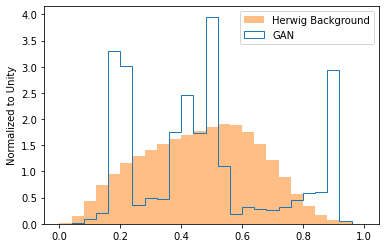

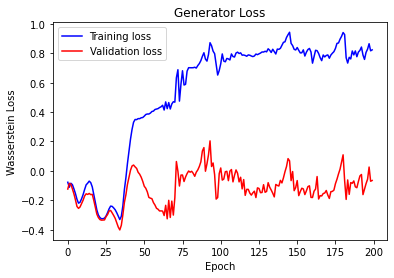

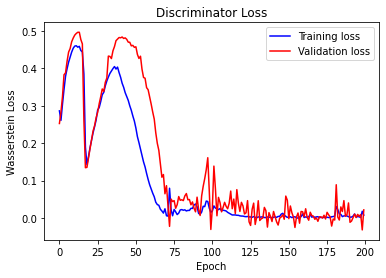

 21%|████████████████▏                                                            | 210/1000 [49:12<3:04:49, 14.04s/it]


Epoch 210:

Generator training loss: 0.7907915416636754
Discriminator training loss: 0.001958910448919114

Generator validation loss: -0.11173819420767613
Discriminator validation loss: 0.002006446914656706


 22%|████████████████▉                                                            | 220/1000 [51:31<3:00:06, 13.85s/it]


Epoch 220:

Generator training loss: 0.7681261919886688
Discriminator training loss: 0.0015858656382183429

Generator validation loss: -0.13835212276851544
Discriminator validation loss: 0.0022432050330384984


 23%|█████████████████▋                                                           | 230/1000 [53:53<3:03:25, 14.29s/it]


Epoch 230:

Generator training loss: 0.7692854251366495
Discriminator training loss: 0.0014068074009280724

Generator validation loss: -0.11260773192663662
Discriminator validation loss: 0.008347278007842433


 24%|██████████████████▍                                                          | 240/1000 [56:14<2:55:54, 13.89s/it]


Epoch 240:

Generator training loss: 0.7532472975267087
Discriminator training loss: 0.002905167316124481

Generator validation loss: -0.13616734926329285
Discriminator validation loss: 0.003627219135404496


 25%|███████████████████▎                                                         | 250/1000 [58:35<2:56:55, 14.15s/it]


Epoch 250:

Generator training loss: 0.7895129026610994
Discriminator training loss: 0.0016724103328182975

Generator validation loss: -0.1750971470944217
Discriminator validation loss: 0.00978168007374033


 26%|███████████████████▌                                                       | 260/1000 [1:00:55<2:52:58, 14.03s/it]


Epoch 260:

Generator training loss: 0.7865007505065105
Discriminator training loss: 0.0026321759688933705

Generator validation loss: -0.16026409226851385
Discriminator validation loss: -0.012625538008325717


 27%|████████████████████▎                                                      | 270/1000 [1:03:17<2:50:20, 14.00s/it]


Epoch 270:

Generator training loss: 0.7534517517181042
Discriminator training loss: 0.0025630254505952512

Generator validation loss: -0.1901952361718553
Discriminator validation loss: 0.0024339150014518547


 28%|█████████████████████                                                      | 280/1000 [1:05:37<2:47:37, 13.97s/it]


Epoch 280:

Generator training loss: 0.7453788383736637
Discriminator training loss: 0.002802840586082311

Generator validation loss: -0.1800727551100684
Discriminator validation loss: -0.008177425914761786


 29%|█████████████████████▊                                                     | 290/1000 [1:07:57<2:44:14, 13.88s/it]


Epoch 290:

Generator training loss: 0.7817492193537332
Discriminator training loss: 0.002478038159862563

Generator validation loss: -0.11064490700354342
Discriminator validation loss: -0.0056156998109115385


 30%|██████████████████████▍                                                    | 299/1000 [1:10:03<2:43:55, 14.03s/it]


Epoch 300:

Generator training loss: 0.7686878288052773
Discriminator training loss: 0.0012814369989557306

Generator validation loss: -0.19508893812289002
Discriminator validation loss: 0.014060480257717618

Epoch 300:


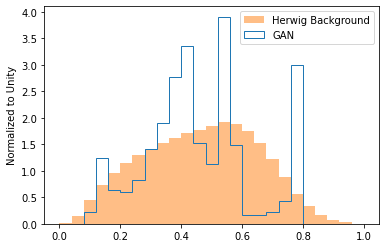

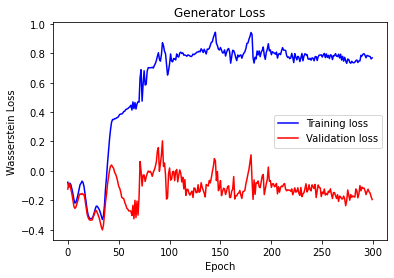

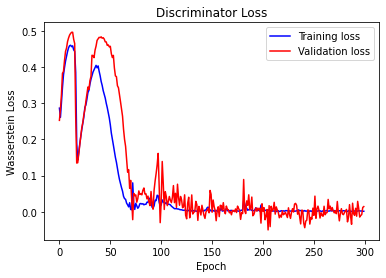

 31%|███████████████████████▎                                                   | 310/1000 [1:12:39<2:43:55, 14.25s/it]


Epoch 310:

Generator training loss: 0.72838280191187
Discriminator training loss: 0.0010355382696839934

Generator validation loss: -0.20567785276741277
Discriminator validation loss: -0.016021940730260226


 32%|████████████████████████                                                   | 320/1000 [1:14:57<2:36:48, 13.84s/it]


Epoch 320:

Generator training loss: 0.7099910397998622
Discriminator training loss: 0.0024754082683604716

Generator validation loss: -0.2180159297145781
Discriminator validation loss: -0.004203794581327038


 33%|████████████████████████▊                                                  | 330/1000 [1:17:16<2:34:31, 13.84s/it]


Epoch 330:

Generator training loss: 0.6850935448714293
Discriminator training loss: 0.001980708150218223

Generator validation loss: -0.26750025116517895
Discriminator validation loss: 0.009358951107925185


 34%|█████████████████████████▌                                                 | 340/1000 [1:19:33<2:30:56, 13.72s/it]


Epoch 340:

Generator training loss: 0.6497765642697694
Discriminator training loss: 0.0007980326091294414

Generator validation loss: -0.2679204275129271
Discriminator validation loss: -0.00512879937598539


 35%|██████████████████████████▎                                                | 350/1000 [1:21:51<2:29:56, 13.84s/it]


Epoch 350:

Generator training loss: 0.6742420264931975
Discriminator training loss: 0.0017160408081861513

Generator validation loss: -0.22050999031692256
Discriminator validation loss: -0.004059427324077138


 36%|███████████████████████████                                                | 360/1000 [1:24:11<2:28:08, 13.89s/it]


Epoch 360:

Generator training loss: 0.6810450122330358
Discriminator training loss: 0.002573634767600321

Generator validation loss: -0.24458220369014583
Discriminator validation loss: 0.006529794286909803


 37%|███████████████████████████▊                                               | 370/1000 [1:26:31<2:29:55, 14.28s/it]


Epoch 370:

Generator training loss: 0.6437198045800944
Discriminator training loss: 0.00281308731338341

Generator validation loss: -0.307492979481572
Discriminator validation loss: 0.027178146503770297


 38%|████████████████████████████▌                                              | 380/1000 [1:28:54<2:27:29, 14.27s/it]


Epoch 380:

Generator training loss: 0.6220968031818098
Discriminator training loss: 0.002598861178223876

Generator validation loss: -0.27886109212871457
Discriminator validation loss: 0.00847239177826731


 39%|█████████████████████████████▎                                             | 390/1000 [1:31:16<2:23:29, 14.11s/it]


Epoch 390:

Generator training loss: 0.640645567673803
Discriminator training loss: 0.0032439051344679017

Generator validation loss: -0.28004114916090106
Discriminator validation loss: 0.0011690599347901774


 40%|█████████████████████████████▉                                             | 399/1000 [1:33:22<2:20:20, 14.01s/it]


Epoch 400:

Generator training loss: 0.67232893317775
Discriminator training loss: 0.0013188096957696001

Generator validation loss: -0.26070956091900344
Discriminator validation loss: 0.017702690722396

Epoch 400:


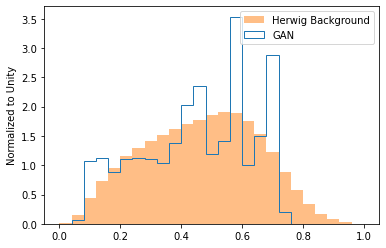

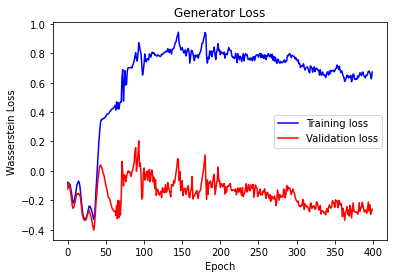

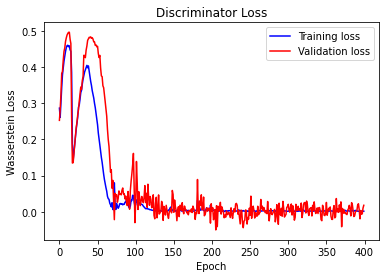

 41%|██████████████████████████████▋                                            | 410/1000 [1:35:58<2:17:41, 14.00s/it]


Epoch 410:

Generator training loss: 0.7141698326895146
Discriminator training loss: 0.00013010940518918195

Generator validation loss: -0.2096268504125173
Discriminator validation loss: -0.012041918014772102


 42%|███████████████████████████████▌                                           | 420/1000 [1:38:17<2:14:47, 13.94s/it]


Epoch 420:

Generator training loss: 0.6435014550151721
Discriminator training loss: 0.0016491871353164391

Generator validation loss: -0.2652765801939808
Discriminator validation loss: -0.007733160153338013


 43%|████████████████████████████████▎                                          | 430/1000 [1:40:35<2:11:25, 13.83s/it]


Epoch 430:

Generator training loss: 0.6237538004182076
Discriminator training loss: 0.0004387485335105165

Generator validation loss: -0.2854633626879239
Discriminator validation loss: -0.004065930786696224


 44%|█████████████████████████████████                                          | 440/1000 [1:42:54<2:09:45, 13.90s/it]


Epoch 440:

Generator training loss: 0.5901269749865505
Discriminator training loss: 0.004068944837856348

Generator validation loss: -0.3711613897905975
Discriminator validation loss: 0.026240609589578644


 45%|█████████████████████████████████▊                                         | 450/1000 [1:45:17<2:10:31, 14.24s/it]


Epoch 450:

Generator training loss: 0.6831509417197743
Discriminator training loss: 0.002034337257868909

Generator validation loss: -0.30170112652856795
Discriminator validation loss: 0.050238485202826866


 46%|██████████████████████████████████▌                                        | 460/1000 [1:47:38<2:07:21, 14.15s/it]


Epoch 460:

Generator training loss: 0.5476415206988653
Discriminator training loss: 0.0027642619308985835

Generator validation loss: -0.3679034177397118
Discriminator validation loss: -0.013001244337933489


 47%|███████████████████████████████████▎                                       | 470/1000 [1:49:58<2:03:27, 13.98s/it]


Epoch 470:

Generator training loss: 0.6722219964194167
Discriminator training loss: 0.001068040924854885

Generator validation loss: -0.24215370624280366
Discriminator validation loss: 0.0059964088746919065


 48%|████████████████████████████████████                                       | 480/1000 [1:52:19<2:01:29, 14.02s/it]


Epoch 480:

Generator training loss: 0.6813012545551759
Discriminator training loss: 0.004133187536775393

Generator validation loss: -0.28139929082549986
Discriminator validation loss: 0.000698160329998469


 49%|████████████████████████████████████▊                                      | 490/1000 [1:54:39<1:58:31, 13.94s/it]


Epoch 490:

Generator training loss: 0.6502387696276597
Discriminator training loss: 0.0011821268310613265

Generator validation loss: -0.3320662310866059
Discriminator validation loss: 0.017406675344765792


 50%|█████████████████████████████████████▍                                     | 499/1000 [1:56:45<1:56:58, 14.01s/it]


Epoch 500:

Generator training loss: 0.6515301664670309
Discriminator training loss: 0.002764448622283602

Generator validation loss: -0.35215317983119215
Discriminator validation loss: 0.02803282269904558

Epoch 500:


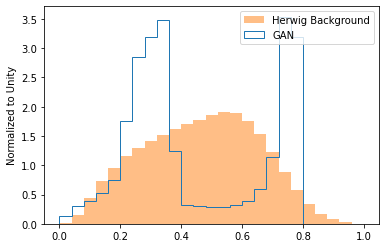

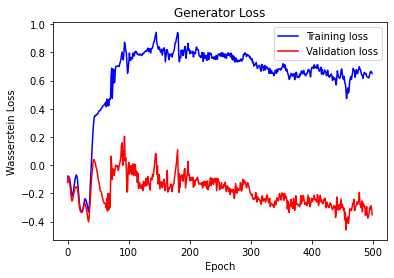

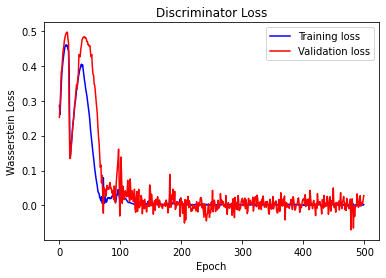

 51%|██████████████████████████████████████▎                                    | 510/1000 [1:59:20<1:53:47, 13.93s/it]


Epoch 510:

Generator training loss: 0.5318019825741241
Discriminator training loss: 0.0008979993045111848

Generator validation loss: -0.40254401794222533
Discriminator validation loss: 0.01455129749706057


 52%|███████████████████████████████████████                                    | 520/1000 [2:01:41<1:54:32, 14.32s/it]


Epoch 520:

Generator training loss: 0.3663971344304215
Discriminator training loss: 0.0011627701605177378

Generator validation loss: -0.4518402221261478
Discriminator validation loss: -0.0016871120352021296


 53%|███████████████████████████████████████▊                                   | 530/1000 [2:04:02<1:52:07, 14.31s/it]


Epoch 530:

Generator training loss: 0.5179785516906957
Discriminator training loss: 0.00228787930749296

Generator validation loss: -0.41538326320101004
Discriminator validation loss: 0.03996855621397892


 54%|████████████████████████████████████████▌                                  | 540/1000 [2:06:22<1:46:33, 13.90s/it]


Epoch 540:

Generator training loss: 0.4503623269131926
Discriminator training loss: 0.006078464157672285

Generator validation loss: -0.5400117870237007
Discriminator validation loss: 0.04114185560677872


 55%|█████████████████████████████████████████▎                                 | 550/1000 [2:08:41<1:44:44, 13.97s/it]


Epoch 550:

Generator training loss: 0.40788398740070114
Discriminator training loss: 0.000931038706228401

Generator validation loss: -0.4640064867304974
Discriminator validation loss: -0.016307702211693663


 56%|██████████████████████████████████████████                                 | 560/1000 [2:11:04<1:45:31, 14.39s/it]


Epoch 560:

Generator training loss: 0.3419938561776297
Discriminator training loss: 0.003142664622602672

Generator validation loss: -0.5761027057639888
Discriminator validation loss: 0.007517736876759388


 57%|██████████████████████████████████████████▋                                | 570/1000 [2:13:26<1:43:03, 14.38s/it]


Epoch 570:

Generator training loss: 0.384129872494708
Discriminator training loss: -0.00035689076237738974

Generator validation loss: -0.5116182455762488
Discriminator validation loss: 0.0009449212046122545


 58%|███████████████████████████████████████████▌                               | 580/1000 [2:15:45<1:37:15, 13.89s/it]


Epoch 580:

Generator training loss: 0.39805681897642836
Discriminator training loss: 0.0020541587959912342

Generator validation loss: -0.5236353024107511
Discriminator validation loss: -0.001454740003893795


 59%|████████████████████████████████████████████▎                              | 590/1000 [2:18:05<1:36:50, 14.17s/it]


Epoch 590:

Generator training loss: 0.4915375032060133
Discriminator training loss: 0.00046976714465479926

Generator validation loss: -0.46128015391162186
Discriminator validation loss: 0.013136125006522129


 60%|████████████████████████████████████████████▉                              | 599/1000 [2:20:11<1:32:44, 13.88s/it]


Epoch 600:

Generator training loss: 0.49823164638600065
Discriminator training loss: 0.002197709080275394

Generator validation loss: -0.4627624290888427
Discriminator validation loss: 0.014794004872559616

Epoch 600:


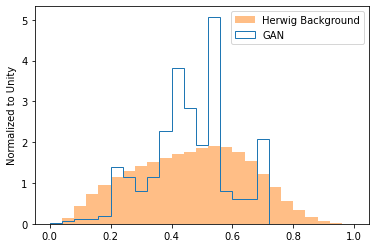

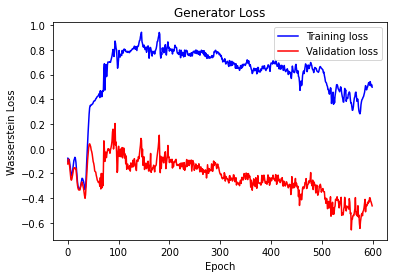

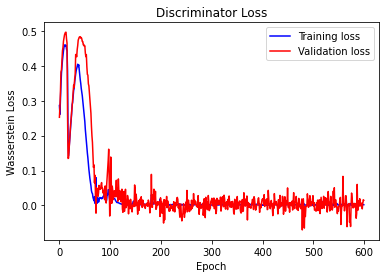

 61%|█████████████████████████████████████████████▊                             | 610/1000 [2:22:43<1:29:52, 13.83s/it]


Epoch 610:

Generator training loss: 0.5687658044972707
Discriminator training loss: -0.0004119960043989338

Generator validation loss: -0.4023504459955653
Discriminator validation loss: -0.0013831761750568194


 62%|██████████████████████████████████████████████▌                            | 620/1000 [2:25:01<1:27:16, 13.78s/it]


Epoch 620:

Generator training loss: 0.5420746445818677
Discriminator training loss: 0.0008931289238423774

Generator validation loss: -0.461477307755439
Discriminator validation loss: -0.0093067174138476


 63%|███████████████████████████████████████████████▎                           | 630/1000 [2:27:20<1:25:13, 13.82s/it]


Epoch 630:

Generator training loss: 0.3508325123477503
Discriminator training loss: 0.011215534801184198

Generator validation loss: -0.6407987118744459
Discriminator validation loss: -0.014854862836578891


 64%|████████████████████████████████████████████████                           | 640/1000 [2:29:43<1:26:15, 14.38s/it]


Epoch 640:

Generator training loss: 0.30638571511038015
Discriminator training loss: 0.0012299446943155195

Generator validation loss: -0.6466740262312968
Discriminator validation loss: -0.007120312175562712


 65%|████████████████████████████████████████████████▊                          | 650/1000 [2:32:05<1:22:35, 14.16s/it]


Epoch 650:

Generator training loss: 0.378646522597537
Discriminator training loss: 0.0016301053259408806

Generator validation loss: -0.6180575128461494
Discriminator validation loss: -0.0075656431772138785


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [2:34:28<1:20:48, 14.26s/it]


Epoch 660:

Generator training loss: 0.3062079267912224
Discriminator training loss: 0.002145564934120746

Generator validation loss: -0.6710410137645534
Discriminator validation loss: -0.026760622135699404


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [2:36:49<1:17:28, 14.09s/it]


Epoch 670:

Generator training loss: 0.23429718764264726
Discriminator training loss: 0.0024284077927856987

Generator validation loss: -0.7304590012206406
Discriminator validation loss: -0.033494427456657906


 68%|███████████████████████████████████████████████████                        | 680/1000 [2:39:11<1:15:59, 14.25s/it]


Epoch 680:

Generator training loss: 0.11382971362012331
Discriminator training loss: 0.0017482949197511401

Generator validation loss: -0.8640587652315859
Discriminator validation loss: 0.012522111753227006


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [2:41:32<1:12:50, 14.10s/it]


Epoch 690:

Generator training loss: 0.03402432984649585
Discriminator training loss: 0.0004078941805584959

Generator validation loss: -0.8893802889057847
Discriminator validation loss: 0.009469762928287696


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [2:43:39<1:10:14, 14.00s/it]


Epoch 700:

Generator training loss: 0.08384460947174793
Discriminator training loss: 0.0017227239708428569

Generator validation loss: -0.8919951588403984
Discriminator validation loss: 0.018046458457409573

Epoch 700:


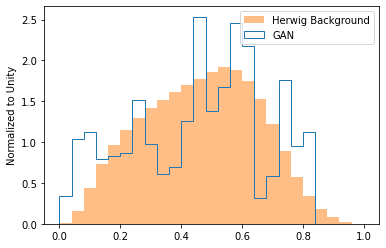

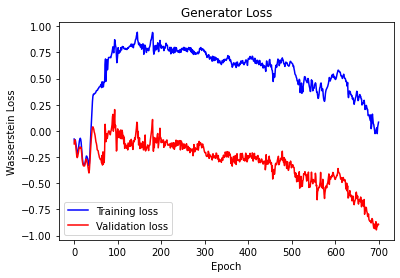

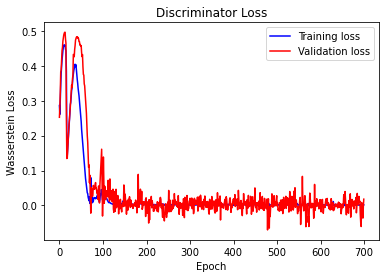

 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [2:46:12<1:06:54, 13.84s/it]


Epoch 710:

Generator training loss: -0.13235417782752698
Discriminator training loss: 0.006176753129359701

Generator validation loss: -1.0850981542321503
Discriminator validation loss: 0.013656006923678224


 72%|██████████████████████████████████████████████████████                     | 720/1000 [2:48:30<1:04:11, 13.76s/it]


Epoch 720:

Generator training loss: 0.02255696608224385
Discriminator training loss: 0.0025234955900044643

Generator validation loss: -0.948813041214083
Discriminator validation loss: -0.01101808163855553


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [2:50:47<1:01:48, 13.74s/it]


Epoch 730:

Generator training loss: 0.06164886337282553
Discriminator training loss: 0.0015040568590679146

Generator validation loss: -0.910016055966987
Discriminator validation loss: 0.005860654147104245


 73%|███████████████████████████████████████████████████████                    | 734/1000 [2:51:42<1:00:41, 13.69s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z